# Basic Pre Processing
making the data cooler

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

In [2]:
def pre_process(path: str) -> list:
    data_v0 = pd.read_csv(path)
    record = {}
    for car in data_v0["vehicle_no"].unique():
        record[car] = [None, None]
    
    for idx, row in data_v0.iterrows():
        car = row["vehicle_no"]
        cam = row["camera_id"]
        t = row["timestamp"]
        
        if cam == 1:
            record[car][0] = t
        elif cam == 2:
            record[car][1] = t
        else:
            raise ValueError("BAD CAM")
    
    data_v1 = []
    for key, val in record.items():
        data_v1.append([key, *val])
    
    return data_v1

ParkingData = pre_process("./air-trafic-prediction/parkingLot (1).csv")

In [3]:
def get_date(t) -> str:
    return (datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S") - datetime.timedelta(minutes=1)).strftime("%Y-%m-%d")

In [4]:
class ForecastStuff:
    TEST_FRAC = 0.2
    FORECAST_DAYS = 7
    
    def __init__(self, data: np.ndarray, title: str):
        self.data = data
        self.title = title
        self.params = None
        self.Y_LABEL = None
        
    
    def display(self, **date_freqs: np.ndarray) -> None:
        plt.figure(figsize=(14, 7))
        for name, date_freq in date_freqs.items():
            plt.plot(date_freq[0], date_freq[1], label=name.replace('_', ' '))
        plt.title(self.title)
        plt.xlabel('Date')
        plt.ylabel(self.Y_LABEL)
        plt.legend()
        plt.show()
    
    def fit(self):
        cutoff = int(self.data.shape[1] * (1 - self.TEST_FRAC))

        train = self.data[:, :cutoff]
        test = self.data[:, cutoff:]
        
        model = ARIMA(list(train[1, :]), **self.params)
        model_fit = model.fit()
        
        predicted = model_fit.forecast(steps=test.shape[1])
        predicted_stuff = test.copy()
        predicted_stuff[1, :] = predicted
        
        self.display(training_data=train, testing_data=test, predicted_data=predicted_stuff)
        
        mase = mean_absolute_scaled_error(test[1, :], predicted, y_train=test[1, :])
        print(f"Mean Absolute Scaled Error (MASE): {mase}")
        
        mape = np.mean(np.abs((test[1, :] - predicted) / test[1, :])) * 100
        print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
    
    def forecast(self) -> None:
        model_fore = ARIMA(list(self.data[1, :]), **self.params)
        model_fore_fit = model_fore.fit()
        predicted = model_fore_fit.forecast(steps=self.FORECAST_DAYS)
        last_date = self.data[0, -1]
        predicted_dates = [last_date + datetime.timedelta(days=i) for i in range(1, self.FORECAST_DAYS + 1)]
        predicted_stuff = np.array([predicted_dates, predicted])
        
        
        self.display(previous_data=self.data, predicted_data=predicted_stuff)

# Q1 A
Forecasting total number of vehicles entering parking per day

In [5]:
def get_date_freq(data: list) -> np.ndarray:
    date_freq_d = {}
    min_date = None
    max_date = None
    for row in data:
        # As long as either entry or exit time is there, it will register (solving the 20minute gap problems)
        
        if row[1]:
            date = get_date(row[1])
        else:
            date = get_date(row[2])
        
        if date not in date_freq_d:
            if not min_date or date < min_date:
                min_date = date
            if not max_date or date > max_date:
                max_date = date
            
            date_freq_d[date] = 1
        else:
            date_freq_d[date] += 1
    
    max_date = datetime.datetime.strptime(max_date, "%Y-%m-%d")
    min_date = datetime.datetime.strptime(min_date, "%Y-%m-%d")
    dates = np.arange(min_date, max_date + datetime.timedelta(days=1), datetime.timedelta(days=1)).astype(datetime.datetime)
    freqs = np.empty(dates.shape)
    freqs[:] = None
    for key, val in date_freq_d.items():
        if val < 100:
            continue # drop absurdly less values since they have missing data
        date = datetime.datetime.strptime(key, "%Y-%m-%d")
        idx = (date - min_date).days
        freqs[idx] = val
    
    out = np.array([dates, freqs])
    
    return out

In [6]:
class ForecastCarNumber(ForecastStuff):
    def __init__(self, data: np.ndarray, title: str = "Car Number"):
        super().__init__(data, title)
        self.params = dict(order=(3, 1, 1), seasonal_order=(2, 1, 0, 7), enforce_stationarity=False, enforce_invertibility=False)
        self.Y_LABEL = "Number of Cars"

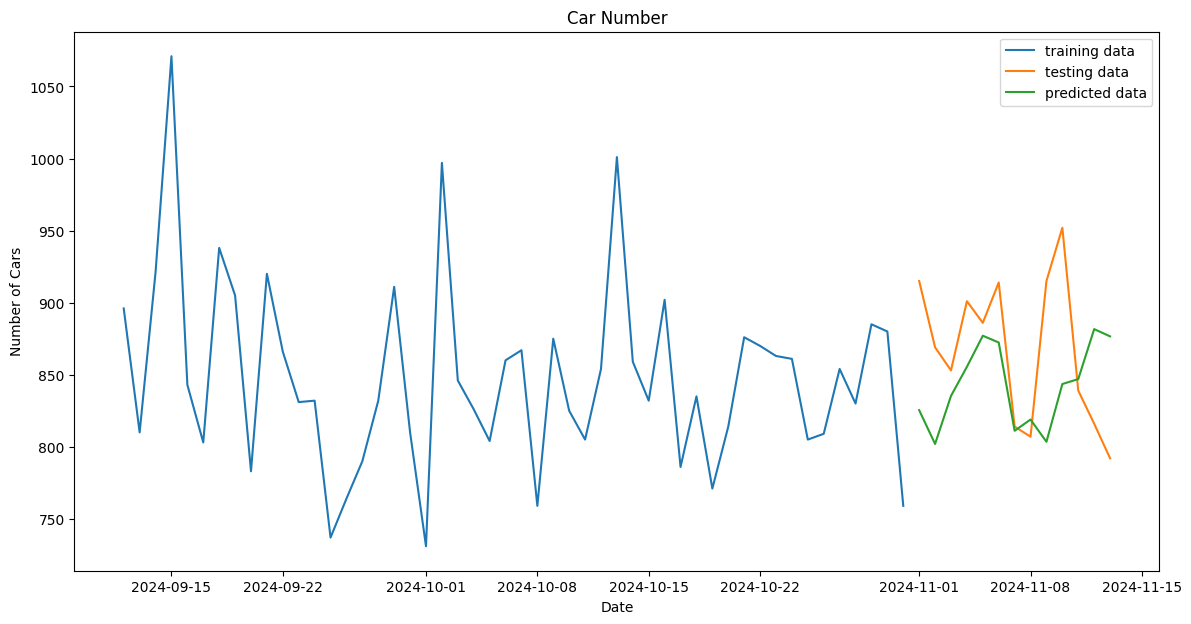

Mean Absolute Scaled Error (MASE): 1.0839801267465763
Mean Absolute Percentage Error (MAPE): 5.79176713346307%


In [7]:
forecast_car_number = ForecastCarNumber(get_date_freq(ParkingData))
forecast_car_number.fit()

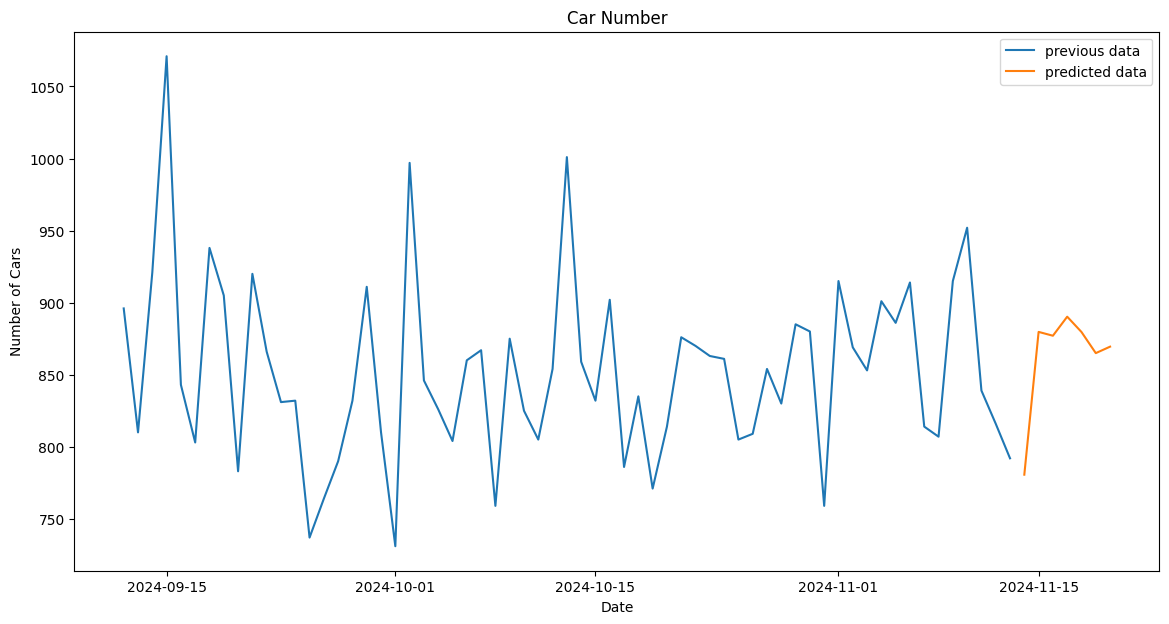

In [8]:
forecast_car_number.forecast()

# Q1 B
Forecasting average parking time per day

In [9]:
def get_park_time(data: list) -> np.ndarray:
    park_time_d = {}
    min_date = None
    max_date = None
    for row in data:
        if row[1] and row[2]:
            date = get_date(row[1])
            
            if date not in park_time_d:
                if not min_date or date < min_date:
                    min_date = date
                if not max_date or date > max_date:
                    max_date = date
                
                park_time_d[date] = []
            
            park_time_d[date].append((datetime.datetime.strptime(row[2], "%Y-%m-%d %H:%M:%S") - datetime.datetime.strptime(row[1], "%Y-%m-%d %H:%M:%S")).seconds / 60)
    
    max_date = datetime.datetime.strptime(max_date, "%Y-%m-%d")
    min_date = datetime.datetime.strptime(min_date, "%Y-%m-%d")
    dates = np.arange(min_date, max_date + datetime.timedelta(days=1), datetime.timedelta(days=1)).astype(datetime.datetime)
    times = np.empty(dates.shape)
    times[:] = None
    
    for key, val in park_time_d.items():
        date = datetime.datetime.strptime(key, "%Y-%m-%d")
        idx = (date - min_date).days
        avg_time = sum(val) / len(val)
        times[idx] = avg_time
    
    return np.array([dates, times])

In [10]:
class ForecastParkTime(ForecastStuff):
    def __init__(self, data: np.ndarray, title: str ="Park time"):
        super().__init__(data, title)
        self.params = dict(order=(2, 1, 1), seasonal_order=(2, 0, 1, 7), enforce_stationarity=False, enforce_invertibility=False)
        self.Y_LABEL = "Average Park Time (Minutes)"

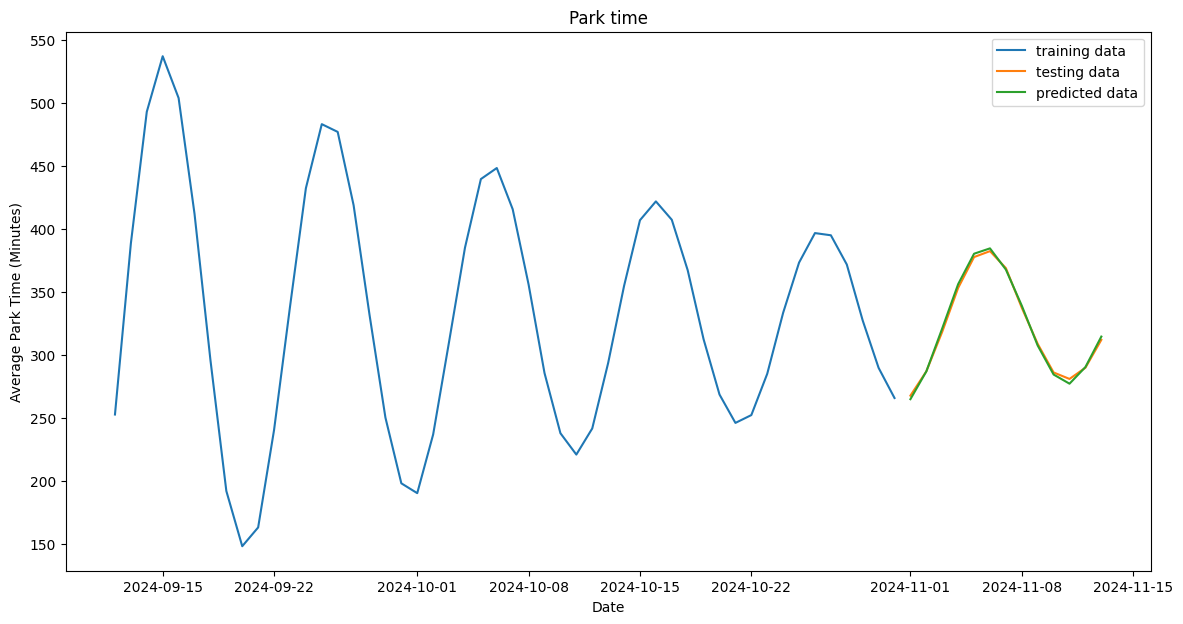

Mean Absolute Scaled Error (MASE): 0.09742427856740939
Mean Absolute Percentage Error (MAPE): 0.6314532445509671%


In [11]:
forecast_park_time = ForecastParkTime(get_park_time(ParkingData))
forecast_park_time.fit()

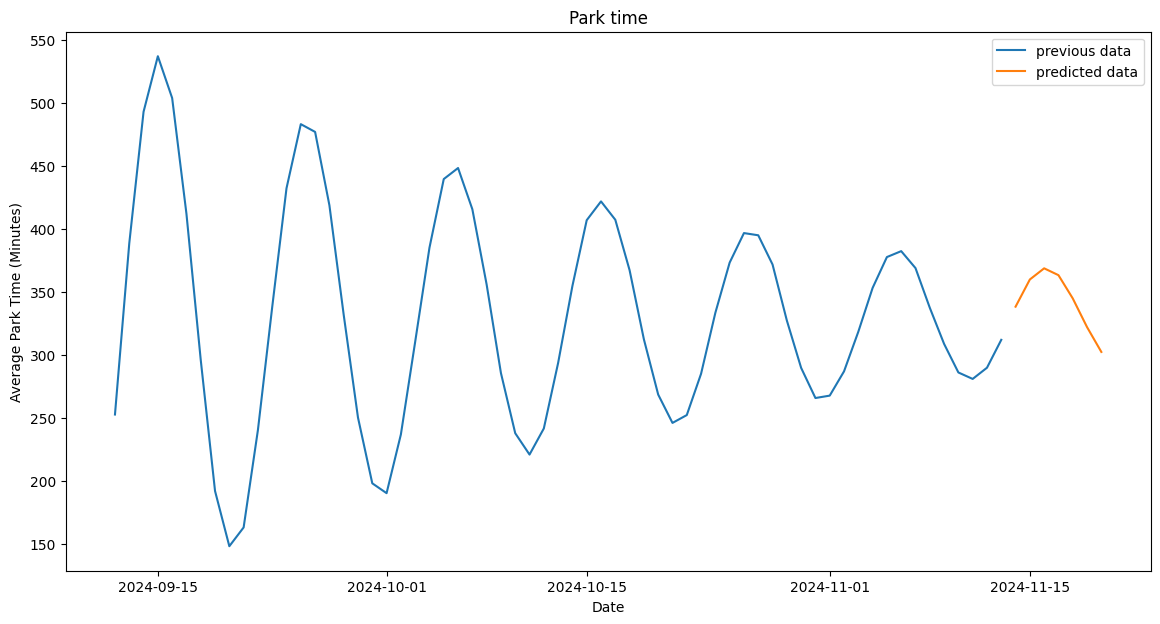

In [12]:
forecast_park_time.forecast()

# Q1 C
Outlier smoothing and Missing value imputation
---
Linear Interpolation

STL Imputation

In [13]:
from statsmodels.tsa.seasonal import STL

In [14]:
MissingParkingData = pre_process("./air-trafic-prediction/parkingLot_missing_values.csv")

In [15]:
def linear_interpolation(data: np.ndarray) -> np.ndarray:
    df = pd.Series(data[1], dtype=float)
    df.interpolate(method='linear', inplace=True)
    return np.array([data[0], df.to_numpy()])

In [16]:
def stl_impuatation(data: np.ndarray):# -> np.ndarray:
    df = pd.Series(data[1], dtype=float)
    
    imputed_indices = df[df.isnull()].index
    
    stl = STL(df.interpolate(), period=7)
    res = stl.fit()
    
    df_deseasonalised = df - res.seasonal
    df_deseasonalised.interpolate(method="linear", inplace=True)
    df_imputed = df_deseasonalised + res.seasonal
     
    df.loc[imputed_indices] = df_imputed[imputed_indices]
    
    return np.array([data[0], df.to_numpy()])

# Car Number

In [17]:
class AdvancedForecastCarNumber(ForecastCarNumber):
    def __init__(self, data: np.ndarray, title: str, display_data: np.ndarray):
        super().__init__(data, title)
        self.display_data = display_data
    
    def display(self, **date_freqs: np.ndarray) -> None:
        plt.figure(figsize=(14, 7))
        plt.plot(self.display_data[0], self.display_data[1], label="actual data")
        for name, date_freq in date_freqs.items():
            plt.plot(date_freq[0], date_freq[1], label=name.replace('_', ' '))
        plt.title(self.title)
        plt.xlabel('Date')
        plt.ylabel(self.Y_LABEL)
        plt.legend()
        plt.show()

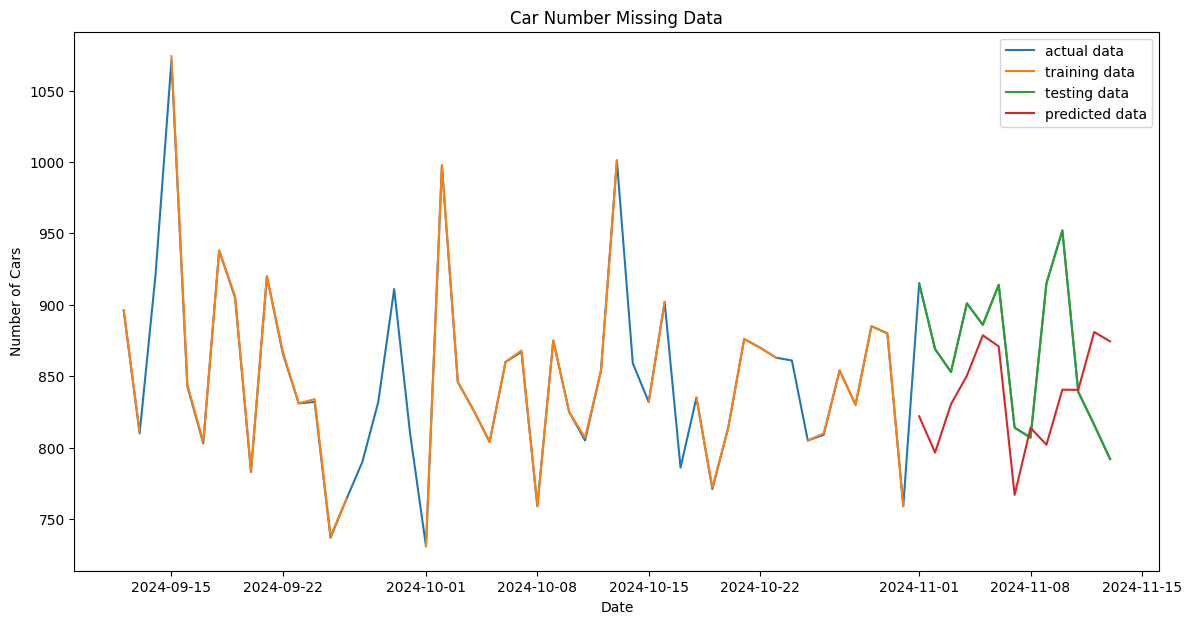

Mean Absolute Scaled Error (MASE): 1.1702713047565476
Mean Absolute Percentage Error (MAPE): 6.272284502723048%


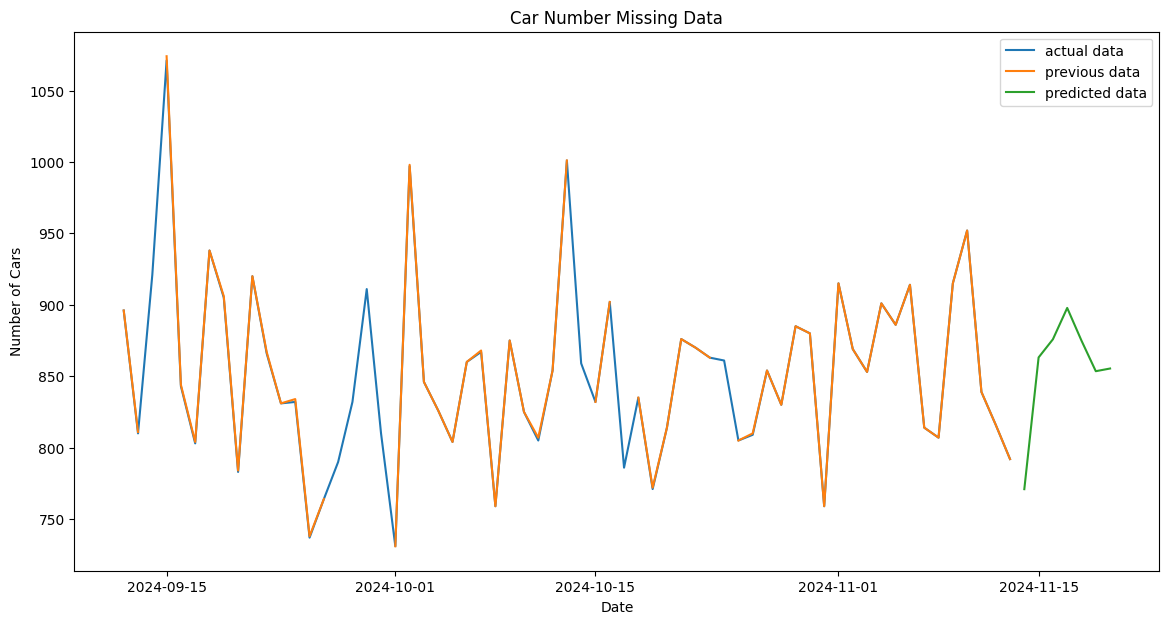

In [18]:
forecast_date_freq = AdvancedForecastCarNumber(get_date_freq(MissingParkingData), "Car Number Missing Data", get_date_freq(ParkingData))
forecast_date_freq.fit()
forecast_date_freq.forecast()

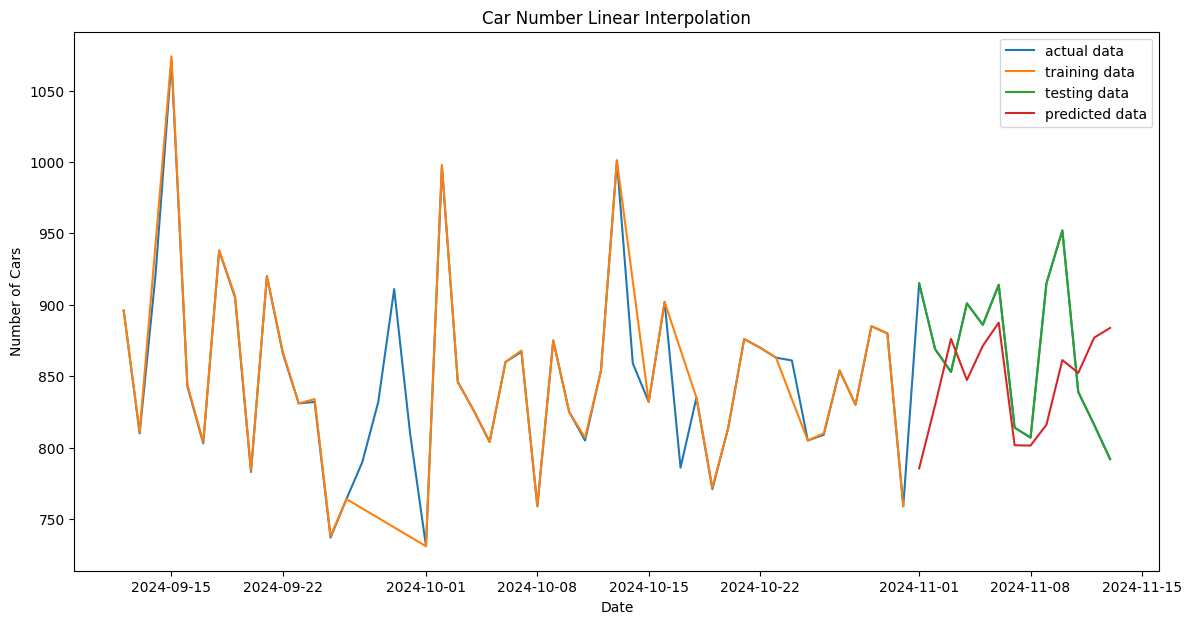

Mean Absolute Scaled Error (MASE): 1.0790405424097085
Mean Absolute Percentage Error (MAPE): 5.77706400473491%


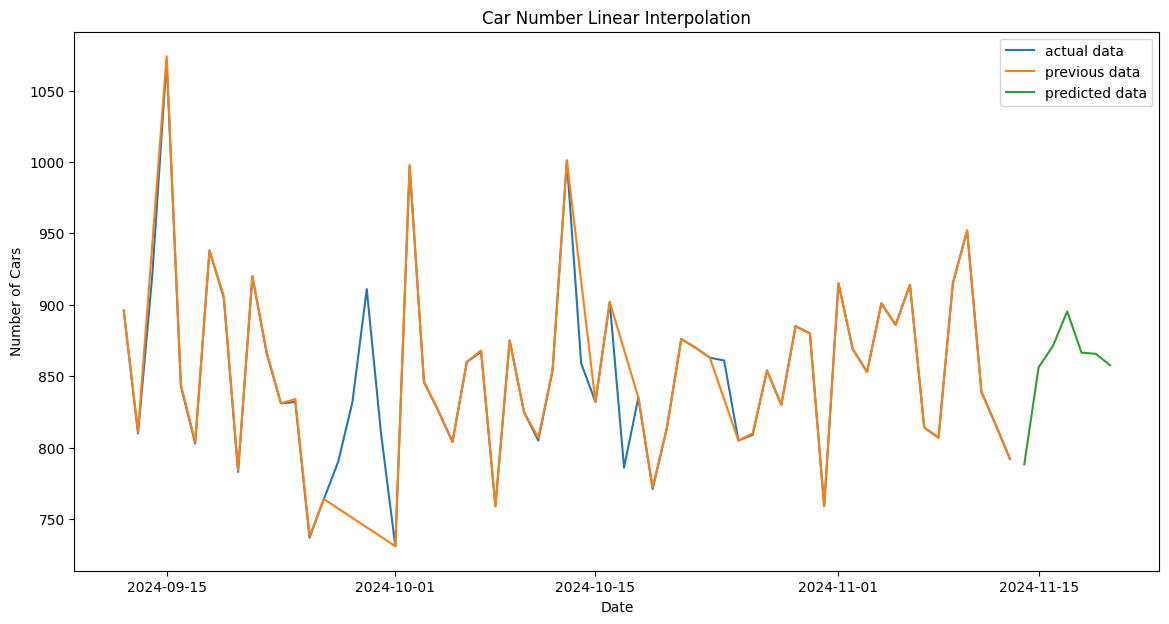

In [19]:
forecast_date_freq = AdvancedForecastCarNumber(linear_interpolation(get_date_freq(MissingParkingData)), "Car Number Linear Interpolation", get_date_freq(ParkingData))
forecast_date_freq.fit()
forecast_date_freq.forecast()

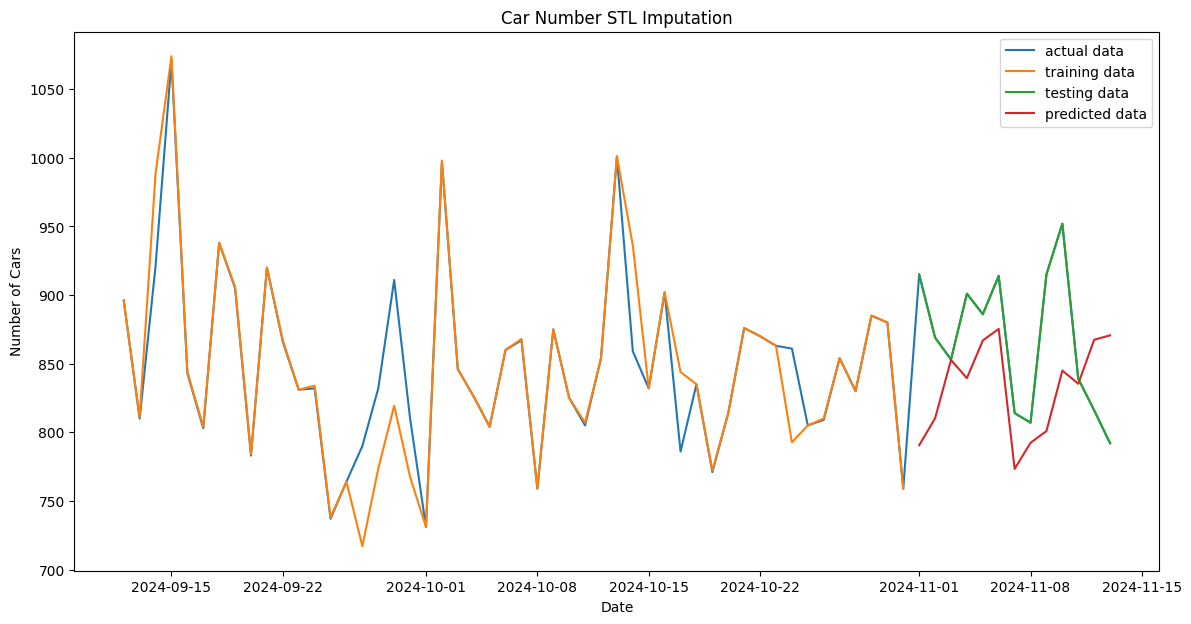

Mean Absolute Scaled Error (MASE): 1.1648321945494908
Mean Absolute Percentage Error (MAPE): 6.215776898428193%


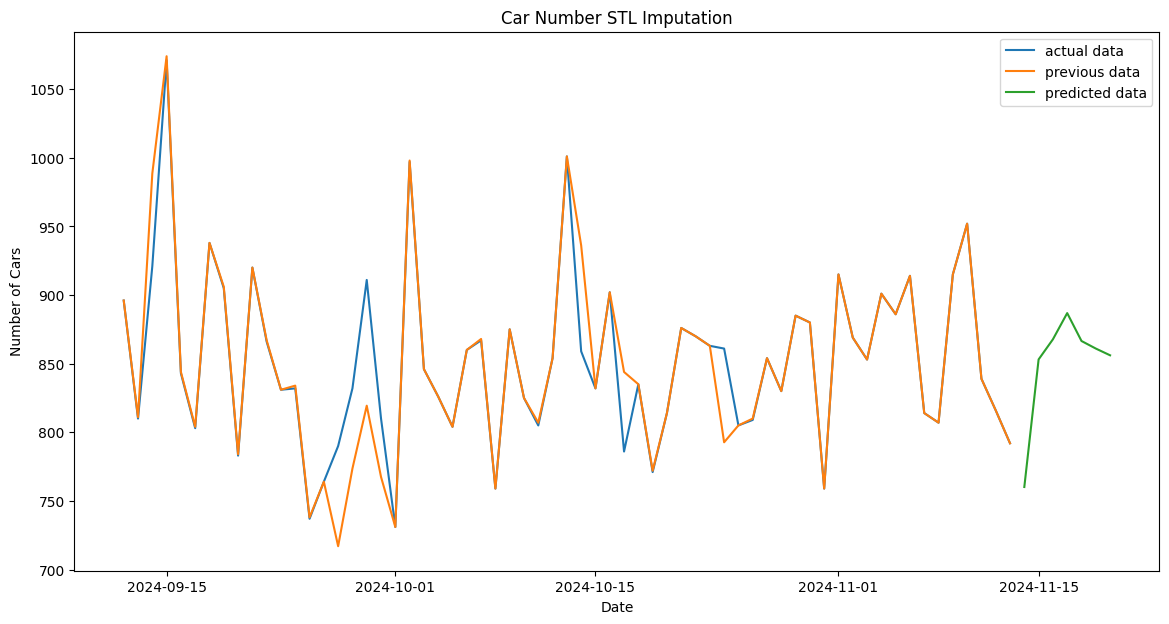

In [20]:
forecast_date_freq = AdvancedForecastCarNumber(stl_impuatation(get_date_freq(MissingParkingData)), "Car Number STL Imputation", get_date_freq(ParkingData))
forecast_date_freq.fit()
forecast_date_freq.forecast()

# Park Time

In [21]:
class AdvancedForecastParkTime(ForecastParkTime):
    def __init__(self, data: np.ndarray, title: str, display_data: np.ndarray):
        super().__init__(data, title)
        self.display_data = display_data
    
    def display(self, **date_freqs: np.ndarray) -> None:
        plt.figure(figsize=(14, 7))
        plt.plot(self.display_data[0], self.display_data[1], label="actual data")
        for name, date_freq in date_freqs.items():
            plt.plot(date_freq[0], date_freq[1], label=name.replace('_', ' '))
        plt.title(self.title)
        plt.xlabel('Date')
        plt.ylabel(self.Y_LABEL)
        plt.legend()
        plt.show()

/home/shawn/Work/iitb/events/data_davinci/repo/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


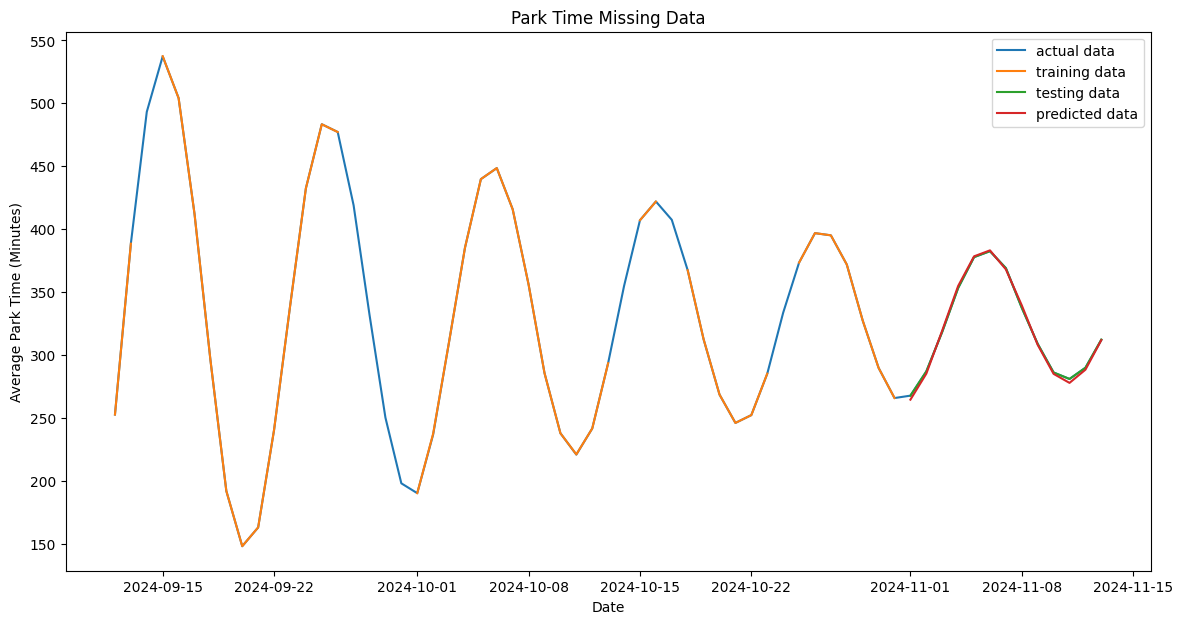

Mean Absolute Scaled Error (MASE): 0.06976062390136104
Mean Absolute Percentage Error (MAPE): 0.47397236518483177%


/home/shawn/Work/iitb/events/data_davinci/repo/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


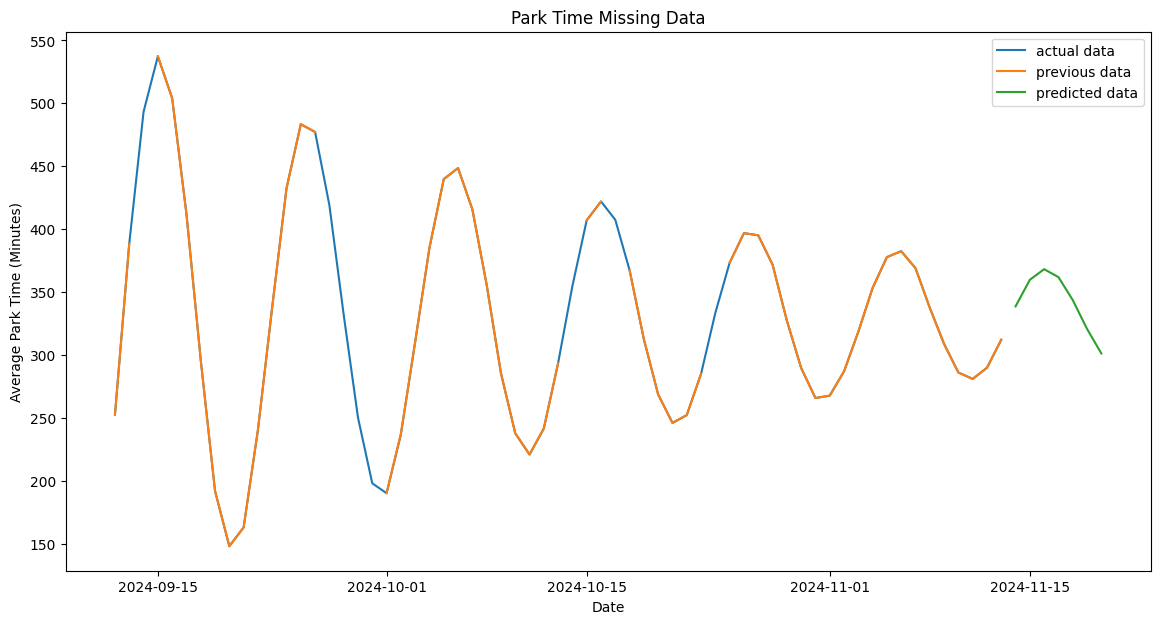

In [22]:
forecast_park_time = AdvancedForecastParkTime(get_park_time(MissingParkingData), "Park Time Missing Data", get_park_time(ParkingData))
forecast_park_time.fit()
forecast_park_time.forecast()

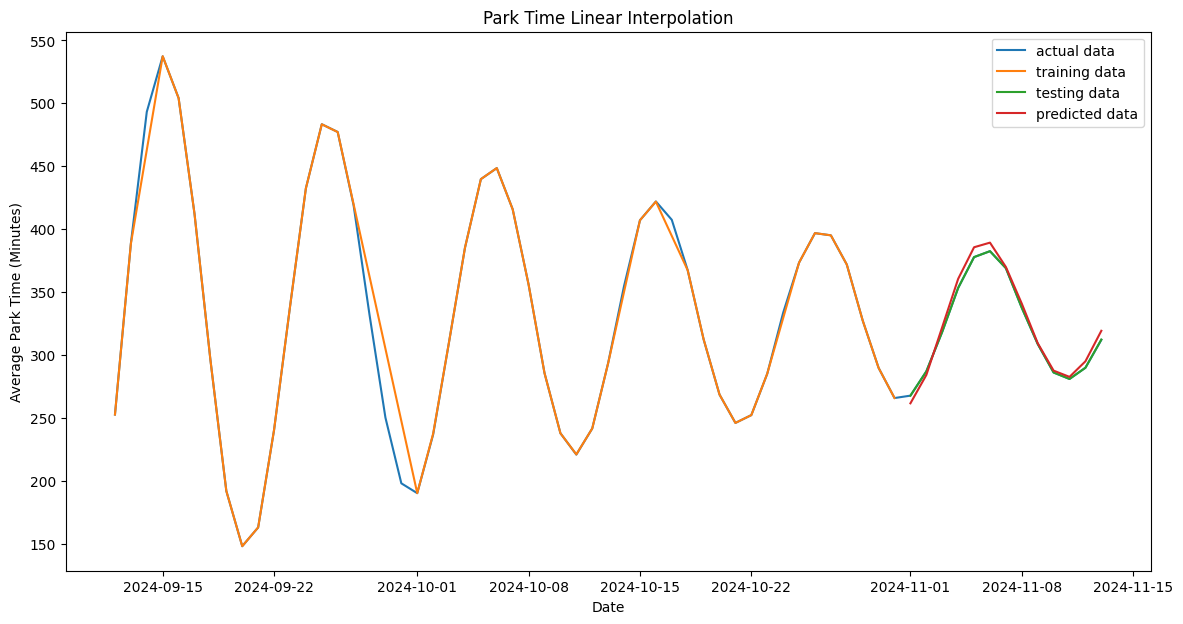

Mean Absolute Scaled Error (MASE): 0.2037175183987146
Mean Absolute Percentage Error (MAPE): 1.2984255104280997%


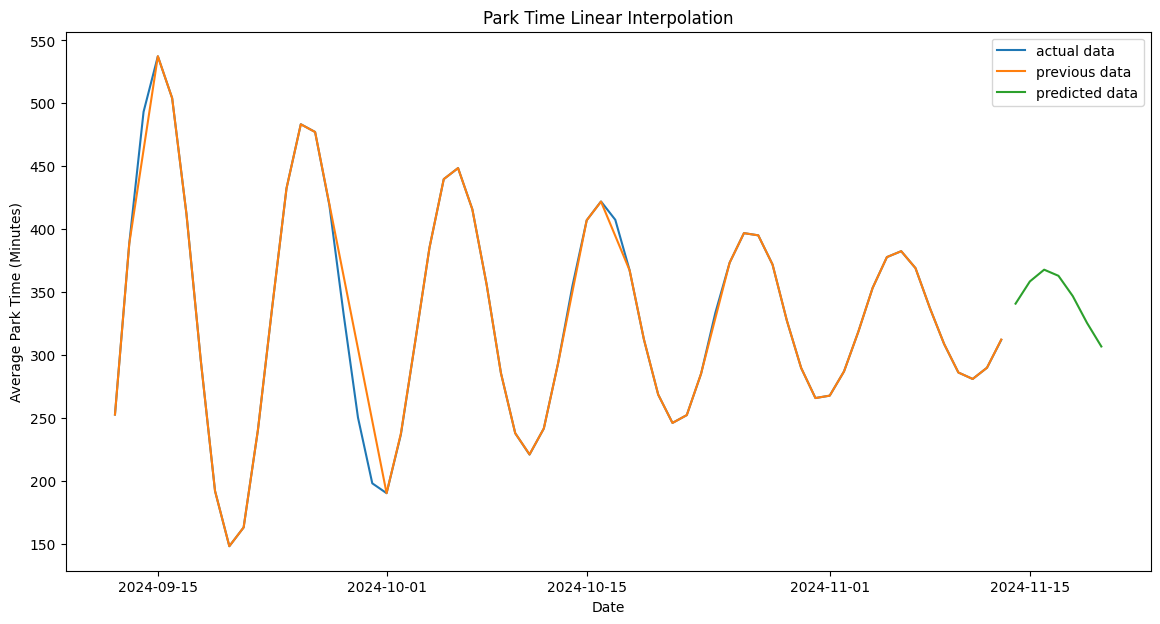

In [23]:
forecast_park_time = AdvancedForecastParkTime(linear_interpolation(get_park_time(MissingParkingData)), "Park Time Linear Interpolation", get_park_time(ParkingData))
forecast_park_time.fit()
forecast_park_time.forecast()

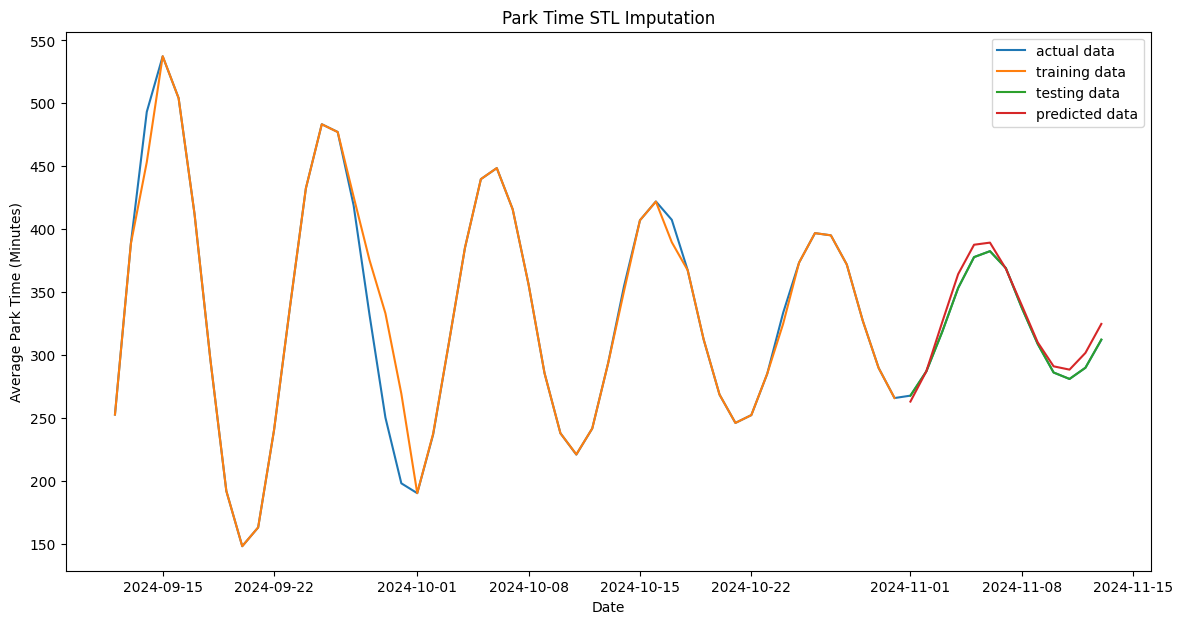

Mean Absolute Scaled Error (MASE): 0.29999561439072775
Mean Absolute Percentage Error (MAPE): 1.9418495332402128%


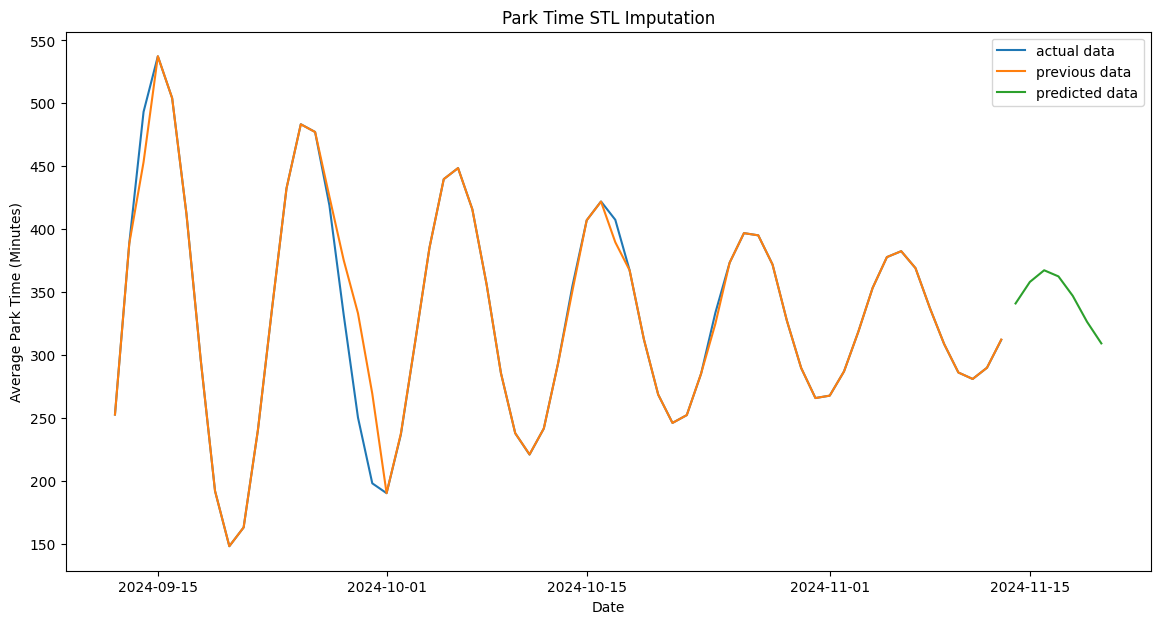

In [24]:
forecast_park_time = AdvancedForecastParkTime(stl_impuatation(get_park_time(MissingParkingData)), "Park Time STL Imputation", get_park_time(ParkingData))
forecast_park_time.fit()
forecast_park_time.forecast()